### CONTENTS:  
    
   1. Introduction
   2. Exploratory Data Analysis
   3. Data Preprocessing
   4. Modeling, Model Evaluation and Model Tuning
       

# 1. Introduction
This study predicts which bank customers will churn by means of machine learning and deep learning techniques. It presents a full machine learning work flow, from exploratory data analysis (completed with both an automated data visualization library and a more classical approach)to the creation of models(with both AutoML libraries and sklearn/keras) and hyperparameter optimization, ensembling the best n models.


### Summary Information about the variables 

* Surname          : The surname of the customer
* CreditScore      : The credit score of the customer
* Geography        : The country of the customer(Germany/France/Spain)
* Gender           : The gender of the customer (Female/Male)
* Age              : The age of the customer  
* Tenure           : The customer's number of years with the bank 
* Balance          : The customer's account balance
* NumOfProducts    : The number of bank products that the customer uses 
* HasCrCard        : Does the customer has a card? (0=No,1=Yes) 
* IsActiveMember   : Does the customer has an active mebership (0=No,1=Yes) 
* EstimatedSalary  : The estimated salary of the customer
* Exited           : Churned or not? (0=No,1=Yes)

In [10]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,KFold
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier,BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [11]:
df = pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [12]:
df.shape

(10000, 14)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [14]:
# function to reduce the memory usage of a dataframe

def reduce_mem_usage(df, verbose=True):
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage before optimization is: {:.2f} MB'.format(start_mem))
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Memory usage decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [15]:
reduce_mem_usage(df)

Memory usage before optimization is: 1.07 MB
Memory usage after optimization is: 0.44 MB
Memory usage decreased by 58.9%


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.000000,1,1,1,101348.882812,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.859375,1,0,1,112542.578125,0
2,3,15619304,Onio,502,France,Female,42,8,159660.796875,3,1,0,113931.570312,1
3,4,15701354,Boni,699,France,Female,39,1,0.000000,2,0,0,93826.632812,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.820312,1,1,1,79084.101562,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.000000,2,1,0,96270.640625,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.609375,1,1,1,101699.773438,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.000000,1,0,1,42085.578125,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.312500,2,1,0,92888.523438,1


In [16]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
RowNumber,10000,NaN,NaN,NaN,5000.5,2886.9,1,2500.75,5000.5,7500.25,10000
CustomerId,10000,NaN,NaN,NaN,1.56909e+07,71936.2,1.55657e+07,1.56285e+07,1.56907e+07,1.57532e+07,1.58157e+07
Surname,10000,2932,Smith,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,10000,NaN,NaN,NaN,650.529,96.6533,350,584,652,718,850
Geography,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,10000,NaN,NaN,NaN,38.9218,10.4878,18,32,37,44,92
Tenure,10000,NaN,NaN,NaN,5.0128,2.89217,0,3,5,7,10
Balance,10000,NaN,NaN,NaN,76485.8,62399,0,0,97198.5,127644,250898
NumOfProducts,10000,NaN,NaN,NaN,1.5302,0.581654,1,1,1,2,4


# 2. Exploratory Data Analysis

Sweetviz is an open-source Python library that generates beautiful, 
high-density visualizations to kickstart EDA (Exploratory Data Analysis) 
with just two lines of code.  It also generates a summarised report with great visualizations.


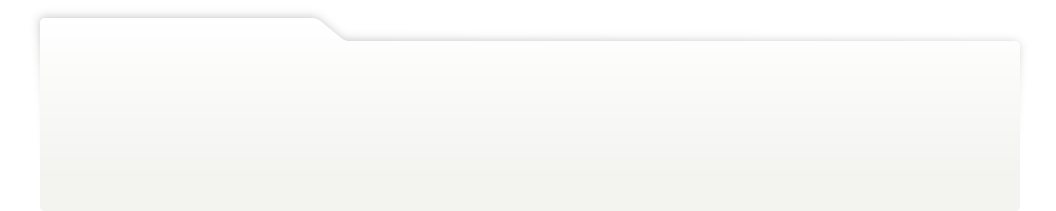
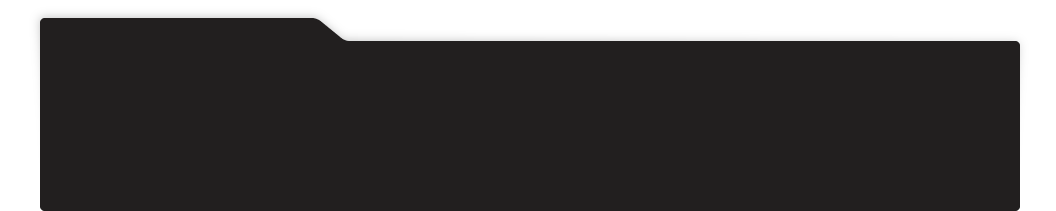
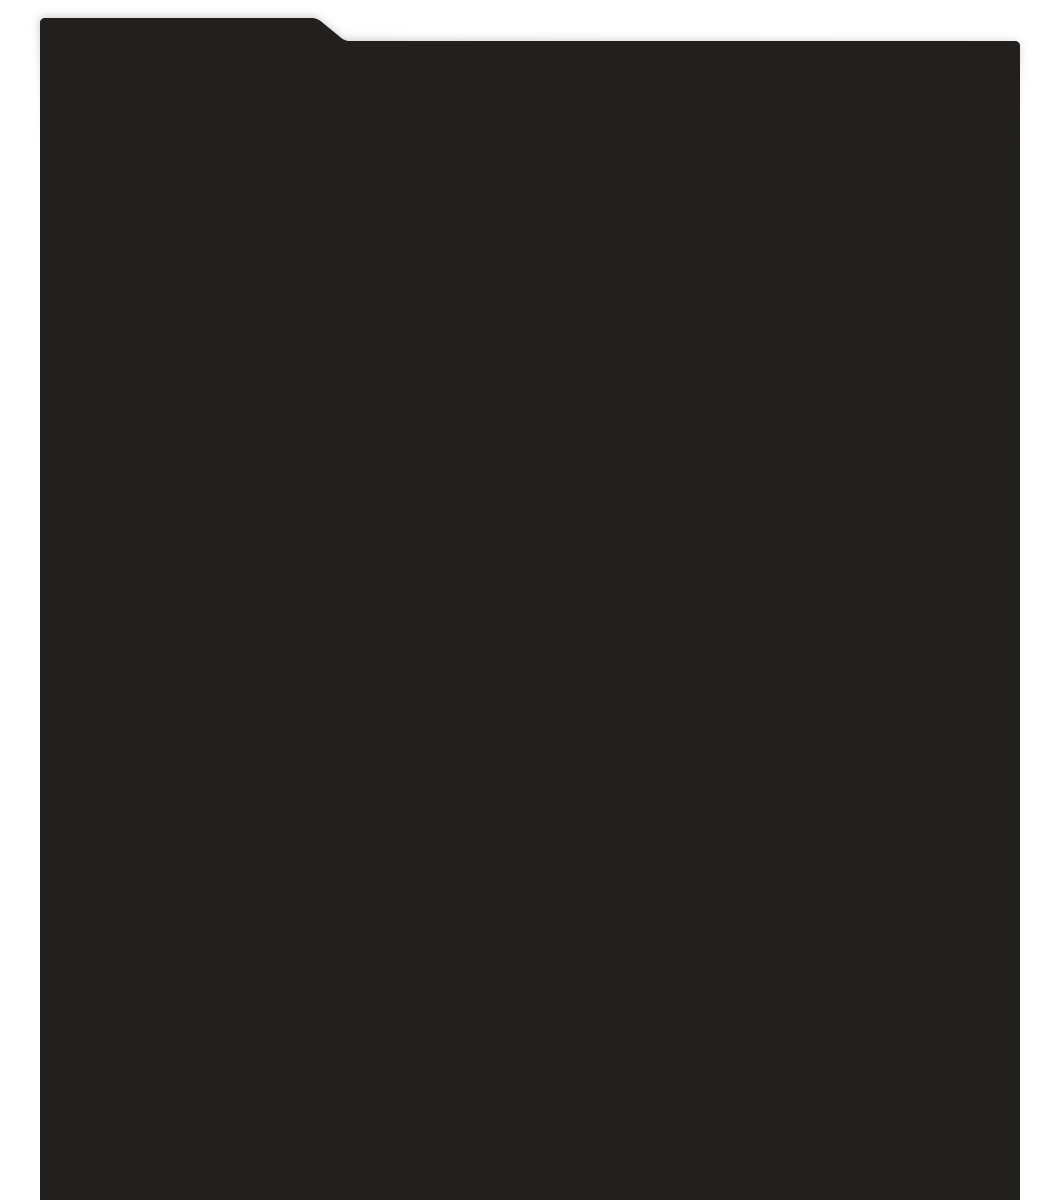
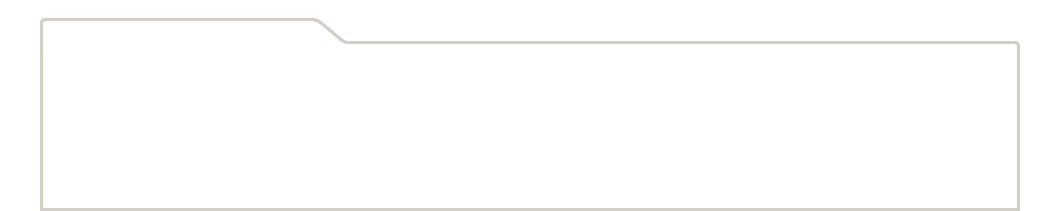
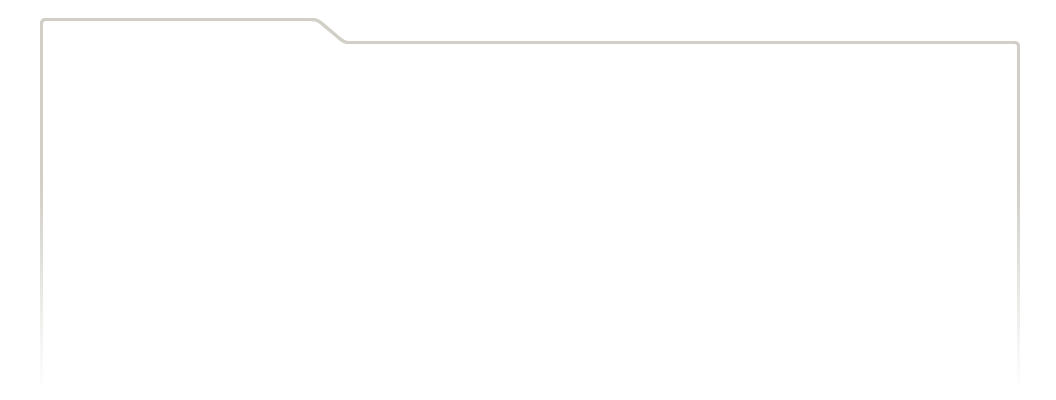
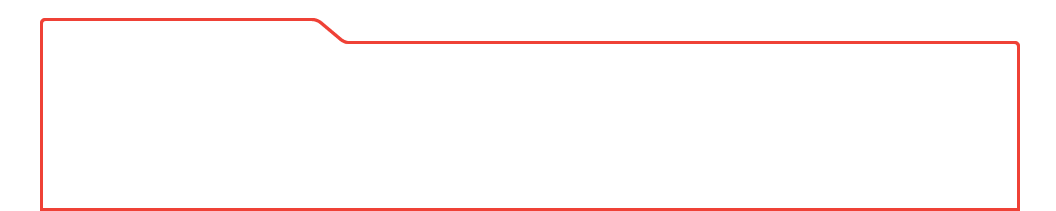
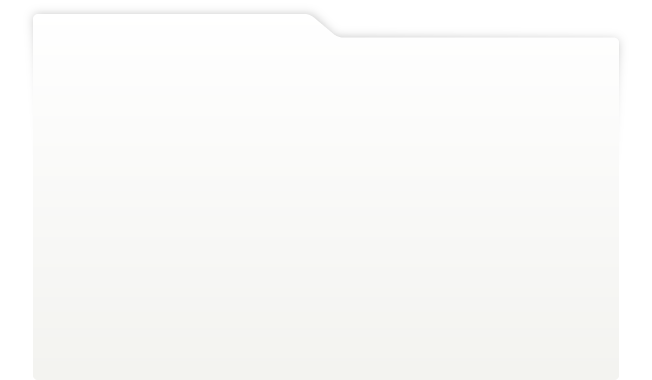
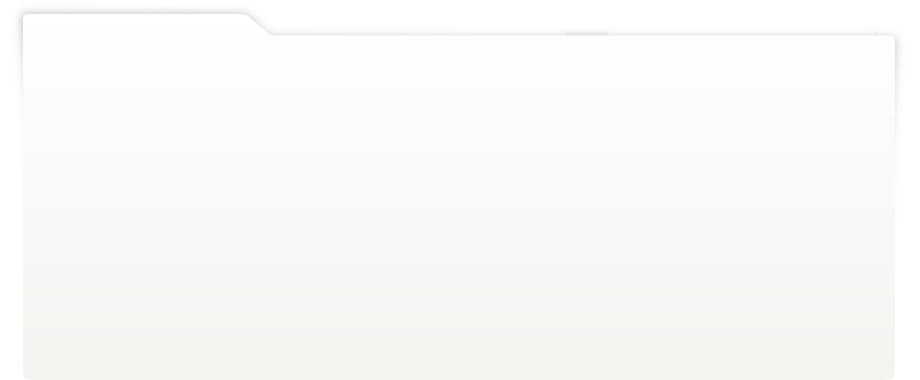
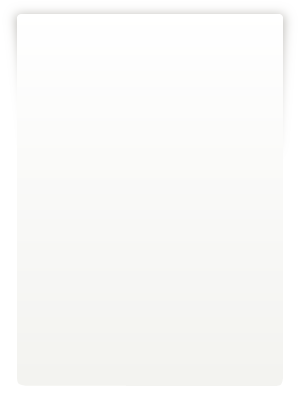
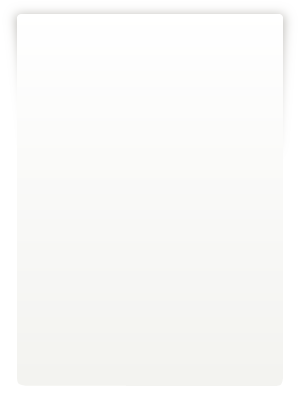
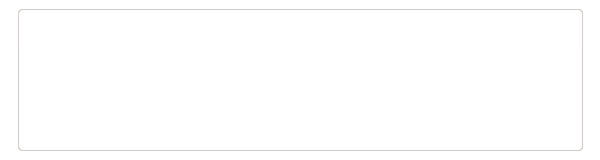
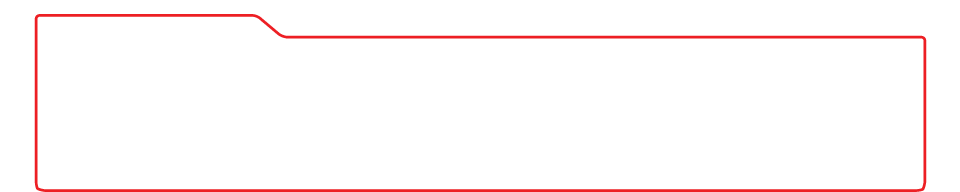
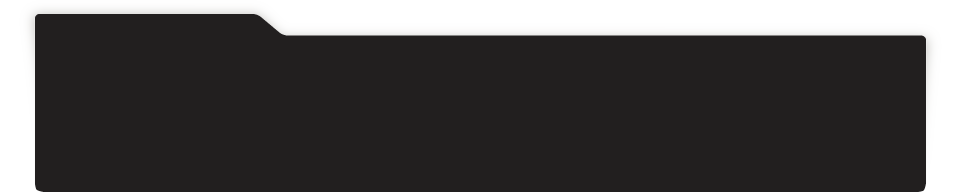
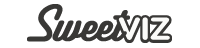
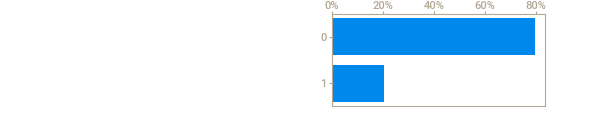
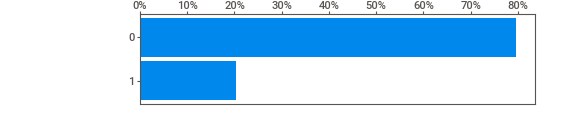
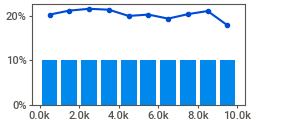
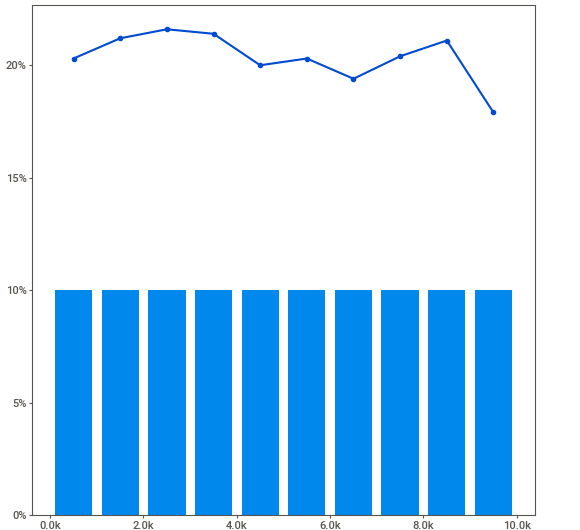
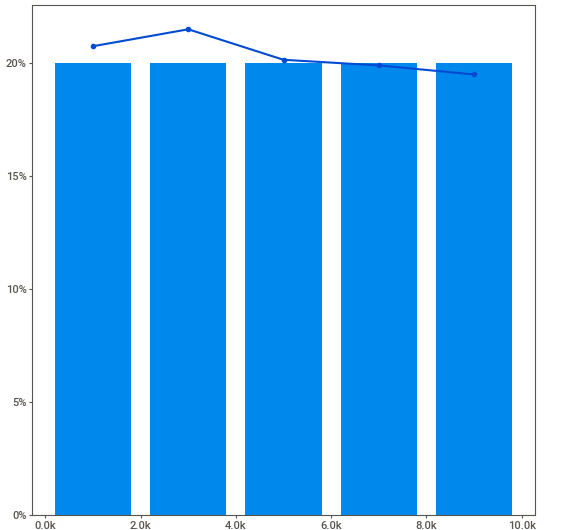
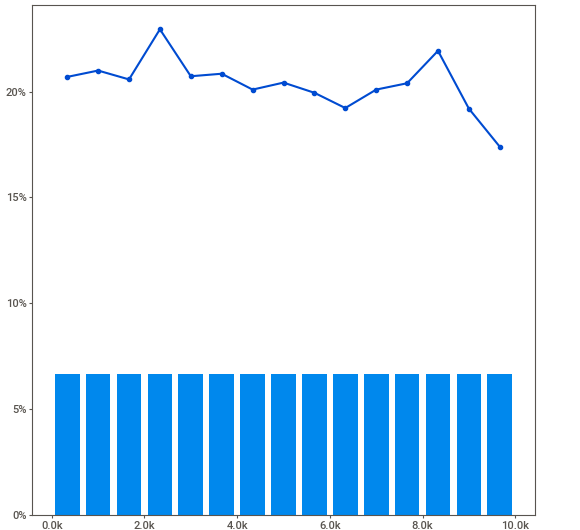
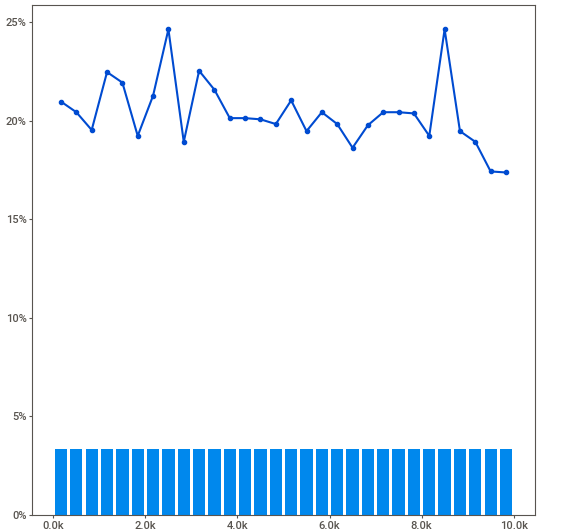
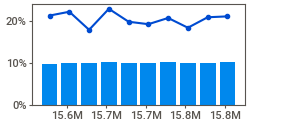
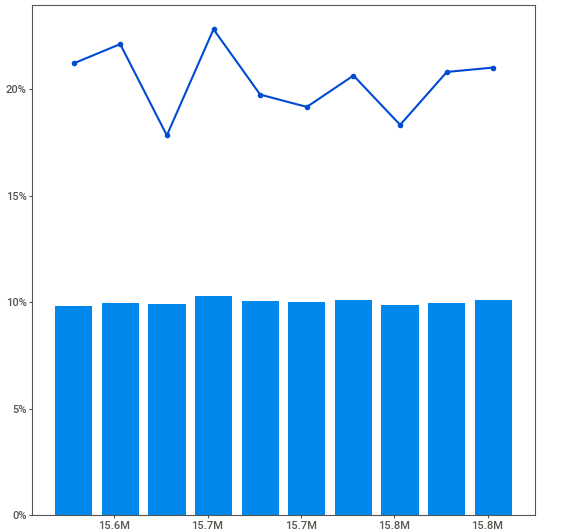
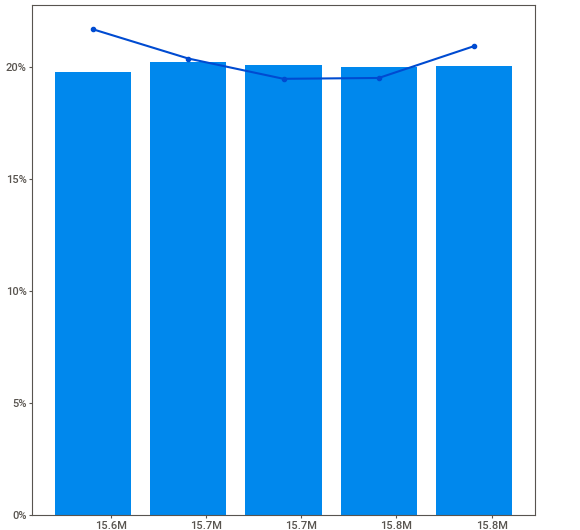
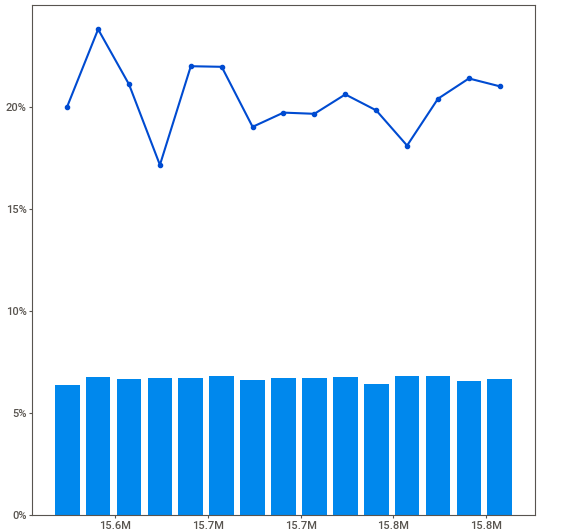
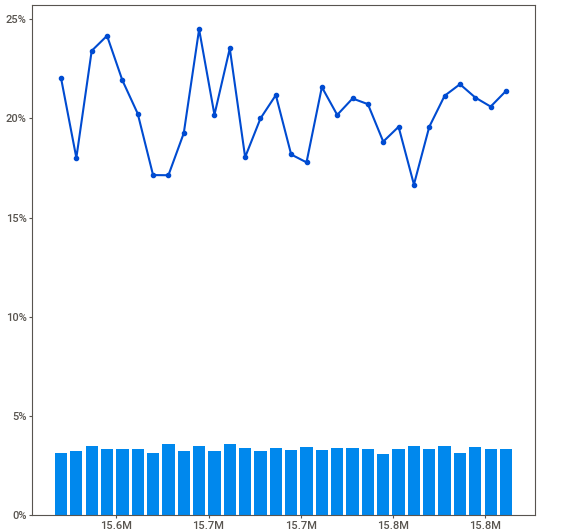
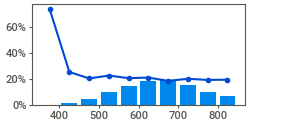
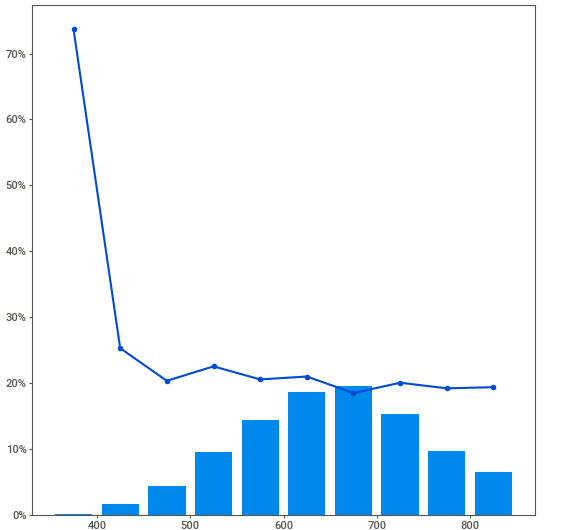
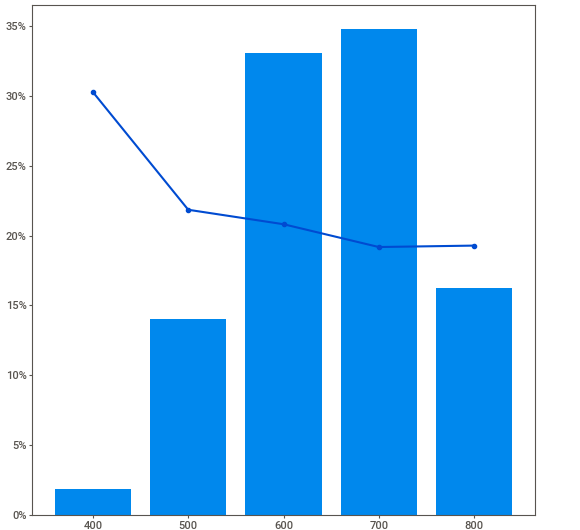
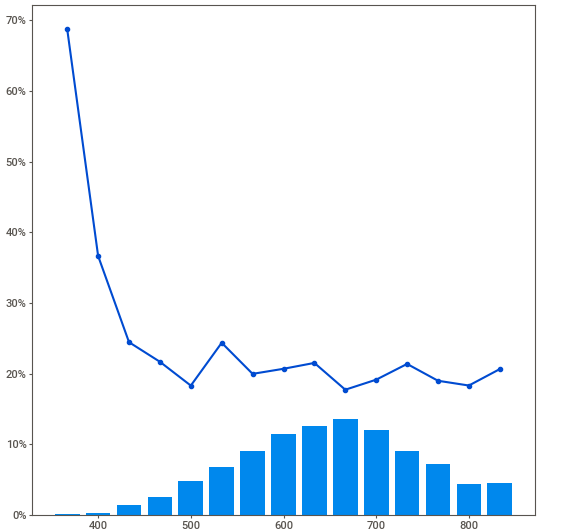
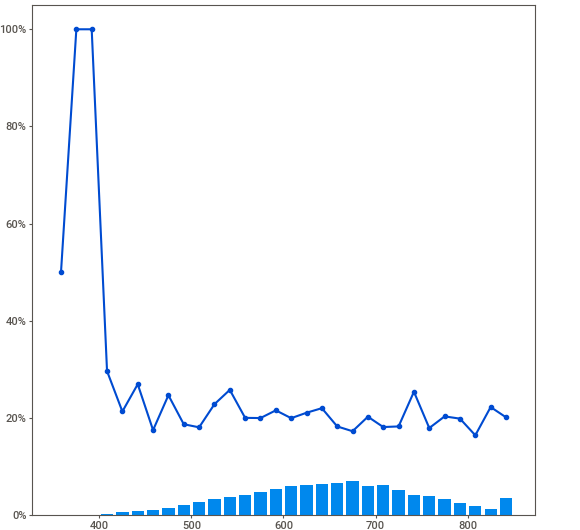
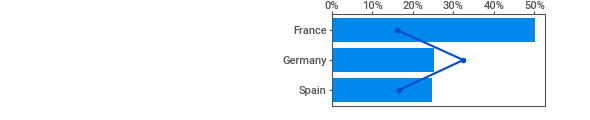
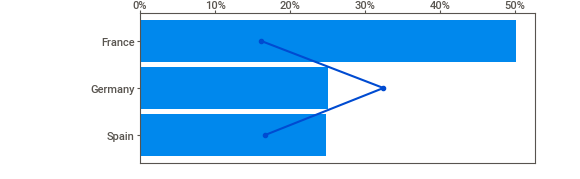
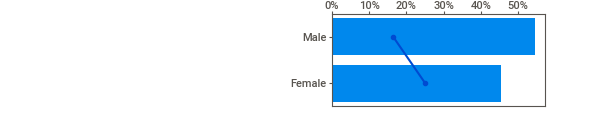
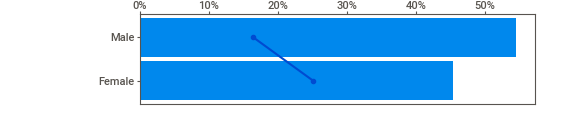
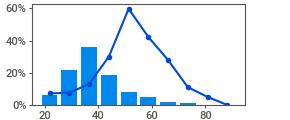
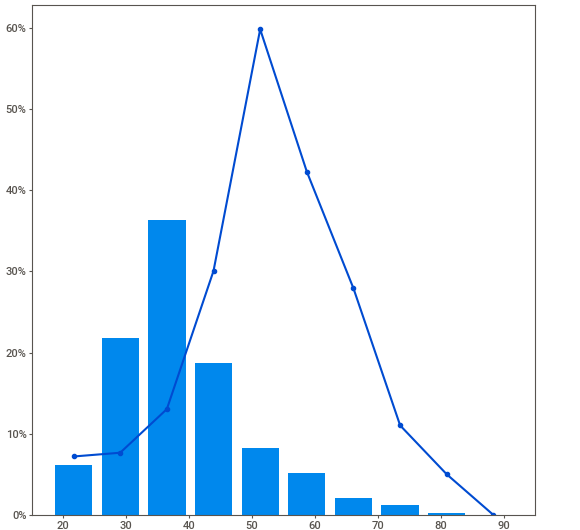
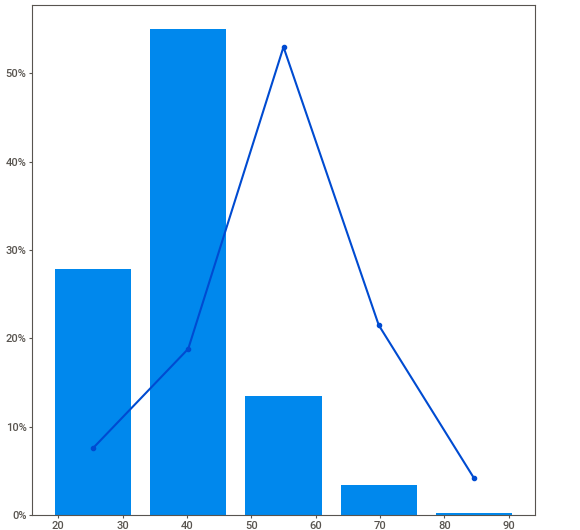
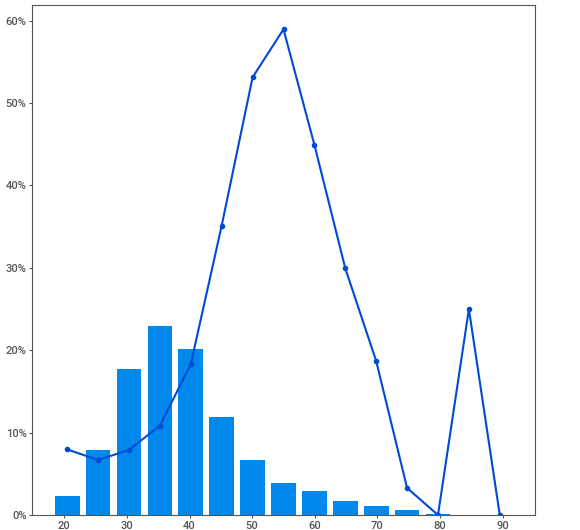
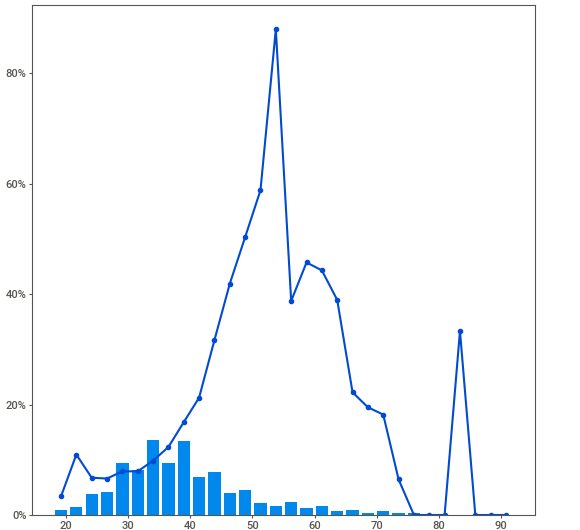
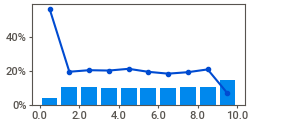
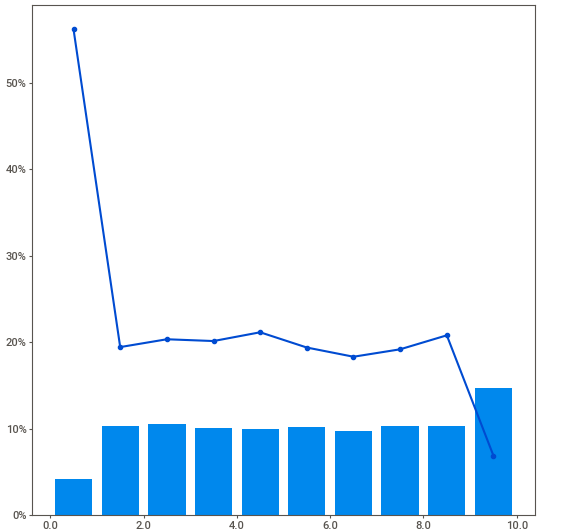
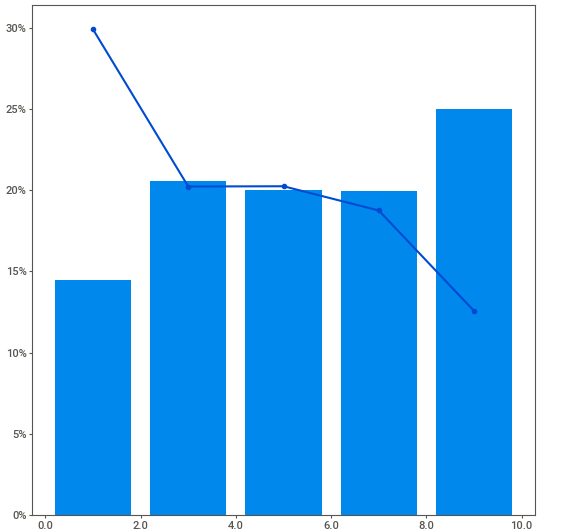
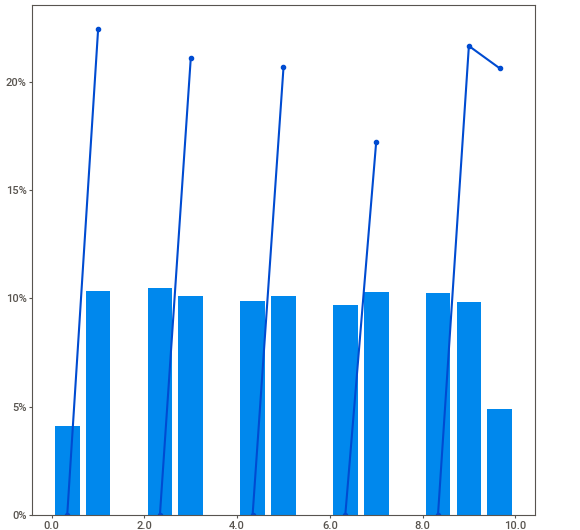
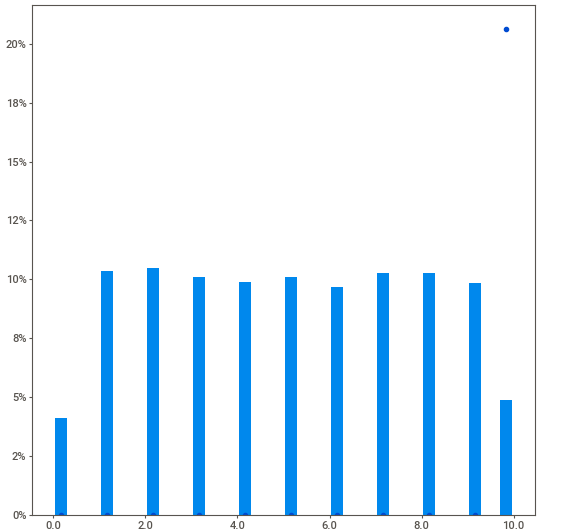
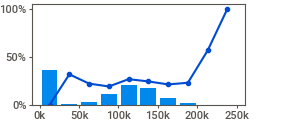
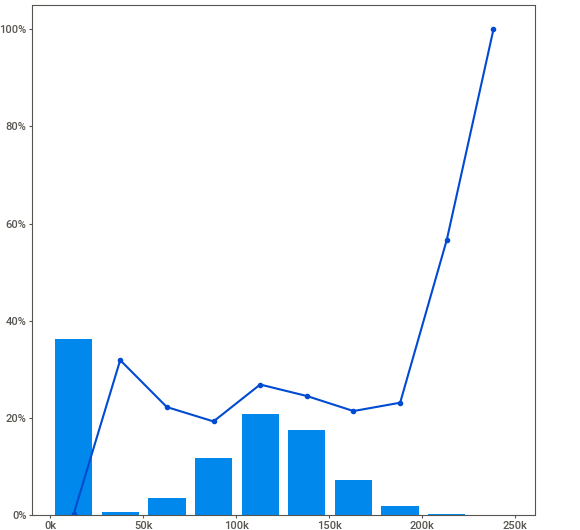
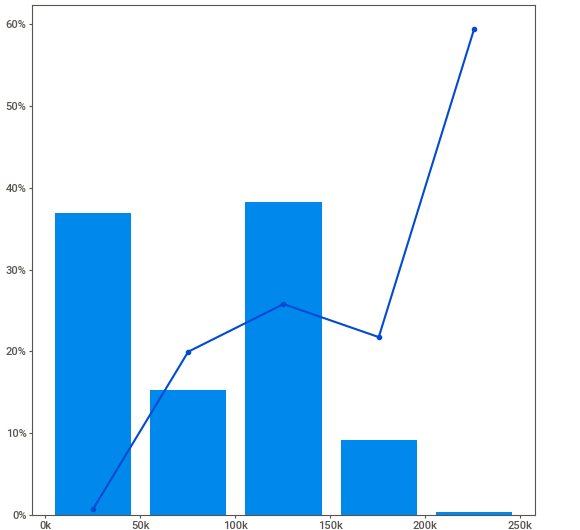
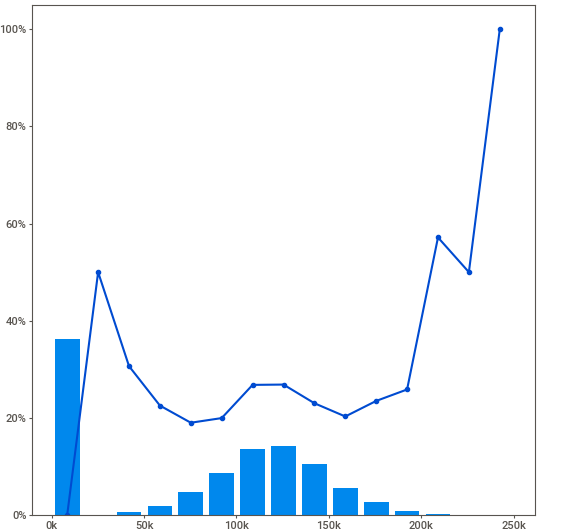
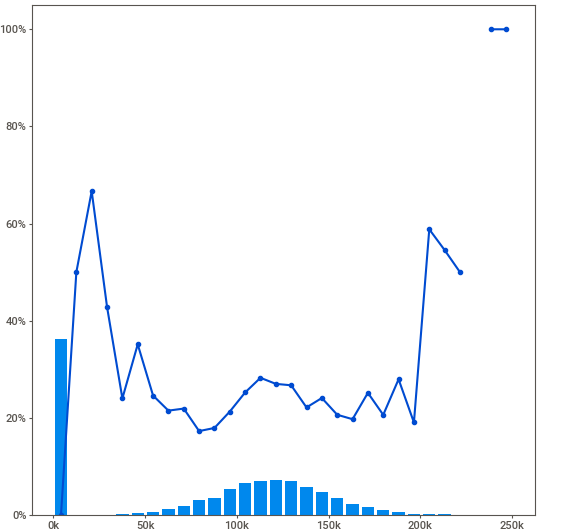
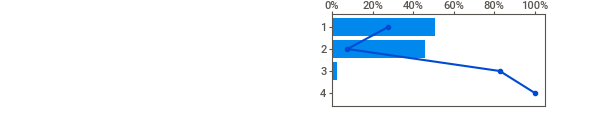
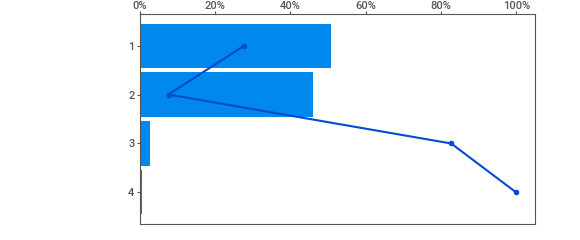
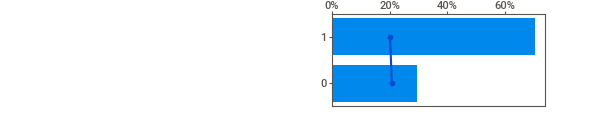
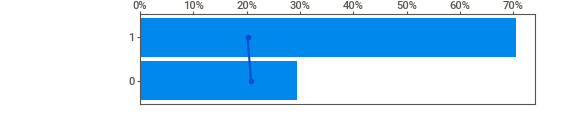
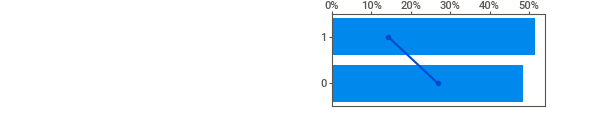
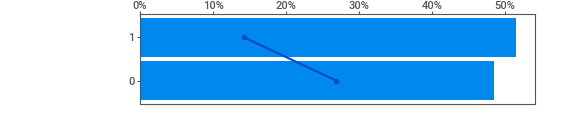
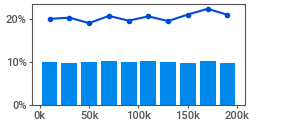
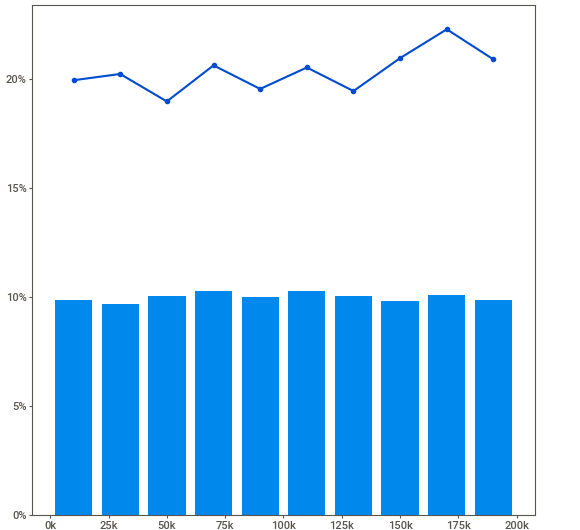
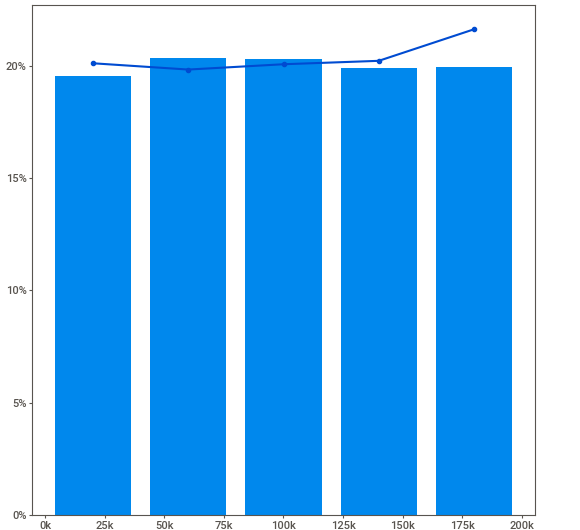
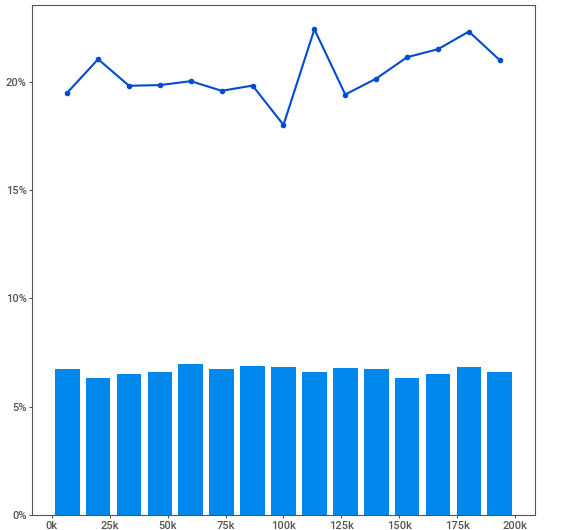
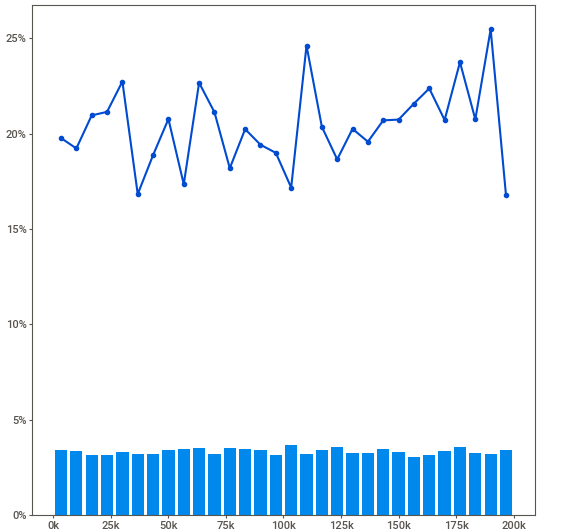
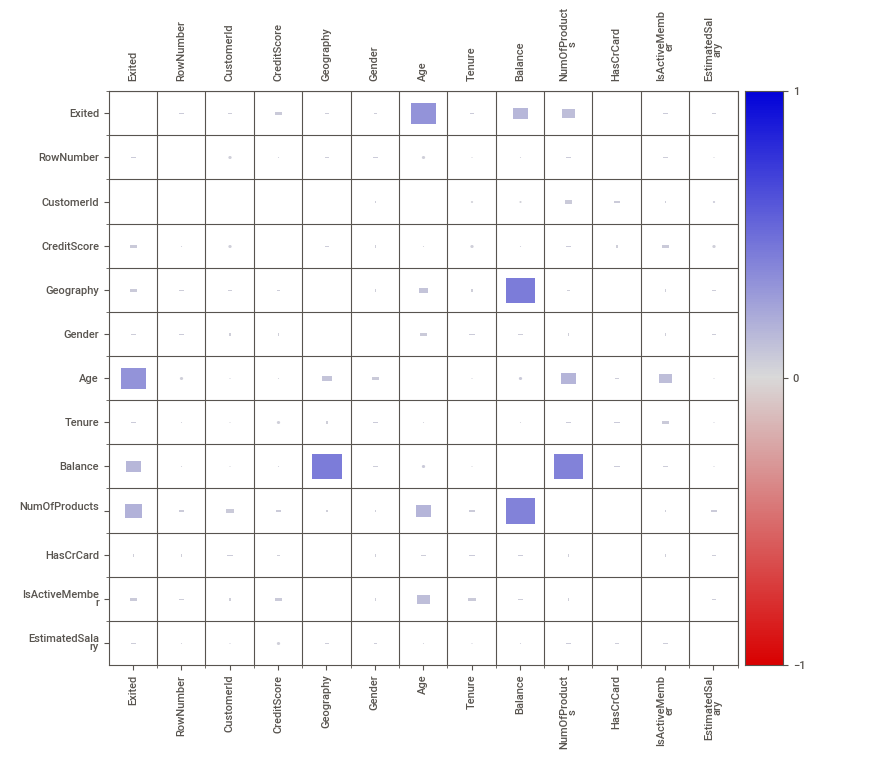
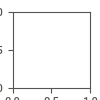

In [17]:
import sweetviz
my_report = sweetviz.analyze(df,target_feat="Exited")
my_report.show_notebook()

In [18]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [19]:
print("{}% of customers left the bank".format(round(df.Exited.mean()*100,2)))

20.37% of customers left the bank


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

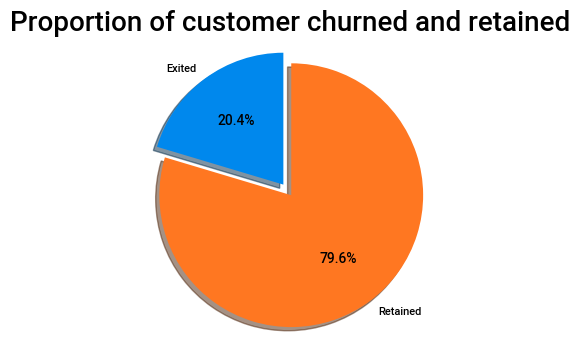

In [65]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(5, 4))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

### Correlation heatmap

<IPython.core.display.Javascript object>

Exited             1.000000
Age                0.285323
Balance            0.118533
EstimatedSalary    0.012097
HasCrCard         -0.007138
Tenure            -0.014001
CreditScore       -0.027094
NumOfProducts     -0.047820
IsActiveMember    -0.156128
Name: Exited, dtype: float64

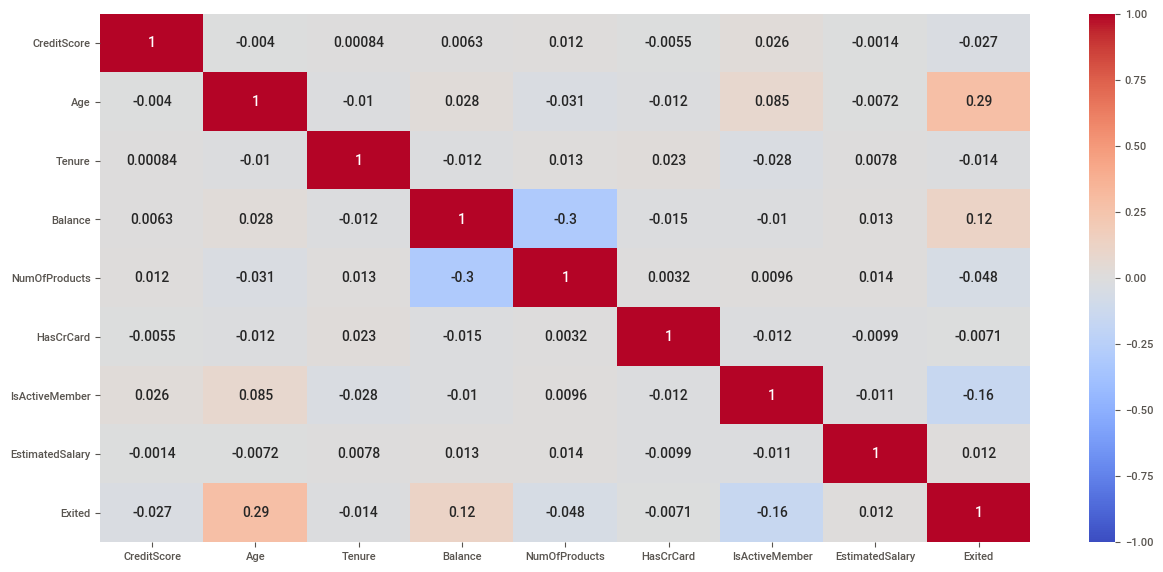

In [20]:
# Corr heatmap
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(), vmin=-1, cmap='coolwarm', annot=True)
df.corr().Exited.sort_values(ascending=False)
# px.imshow(df.corr())

###  Churn probability vs all features
The 'mean' column corresponds to the ratio of customers who left the bank.

In [21]:
for feature in df:
    
        if feature != 'Exited':
            
            if len(list(df[feature].unique())) <= 11:
                    display(df.groupby(feature)["Exited"].describe())
                    
            else:
                display(df.groupby(pd.qcut(df[feature], q=10,duplicates="drop"))["Exited"].describe())
                      

,count,mean,std,min,25%,50%,75%,max
CreditScore,,,,,,,,
"(349.999, 521.0]",1002.0,0.223553,0.416834,0.0,0.0,0.0,0.0,1.0
"(521.0, 566.0]",1008.0,0.226190,0.418572,0.0,0.0,0.0,0.0,1.0
"(566.0, 598.7]",990.0,0.200000,0.400202,0.0,0.0,0.0,0.0,1.0
"(598.7, 627.0]",1030.0,0.216505,0.412062,0.0,0.0,0.0,0.0,1.0
"(627.0, 652.0]",1005.0,0.207960,0.406050,0.0,0.0,0.0,0.0,1.0
"(652.0, 678.0]",1005.0,0.185075,0.388551,0.0,0.0,0.0,0.0,1.0
"(678.0, 704.0]",978.0,0.174847,0.380030,0.0,0.0,0.0,0.0,1.0
"(704.0, 735.0]",1003.0,0.191426,0.393620,0.0,0.0,0.0,0.0,1.0
"(735.0, 778.0]",998.0,0.210421,0.407812,0.0,0.0,0.0,0.0,1.0


,count,mean,std,min,25%,50%,75%,max
Geography,,,,,,,,
France,5014.0,0.161548,0.368072,0.0,0.0,0.0,0.0,1.0
Germany,2509.0,0.324432,0.468256,0.0,0.0,0.0,1.0,1.0
Spain,2477.0,0.166734,0.372813,0.0,0.0,0.0,0.0,1.0


,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
Female,4543.0,0.250715,0.433473,0.0,0.0,0.0,1.0,1.0
Male,5457.0,0.164559,0.370816,0.0,0.0,0.0,0.0,1.0


,count,mean,std,min,25%,50%,75%,max
Age,,,,,,,,
"(17.999, 27.0]",1020.0,0.071569,0.257899,0.0,0.0,0.0,0.0,1.0
"(27.0, 31.0]",1352.0,0.079882,0.271210,0.0,0.0,0.0,0.0,1.0
"(31.0, 33.0]",860.0,0.088372,0.284000,0.0,0.0,0.0,0.0,1.0
"(33.0, 35.0]",921.0,0.097720,0.297097,0.0,0.0,0.0,0.0,1.0
"(35.0, 37.0]",934.0,0.123126,0.328758,0.0,0.0,0.0,0.0,1.0
"(37.0, 40.0]",1332.0,0.168168,0.374156,0.0,0.0,0.0,0.0,1.0
"(40.0, 42.0]",687.0,0.212518,0.409388,0.0,0.0,0.0,0.0,1.0
"(42.0, 46.0]",1009.0,0.335976,0.472565,0.0,0.0,0.0,1.0,1.0
"(46.0, 53.0]",919.0,0.514690,0.500056,0.0,0.0,1.0,1.0,1.0


,count,mean,std,min,25%,50%,75%,max
Tenure,,,,,,,,
0,413.0,0.230024,0.421358,0.0,0.0,0.0,0.0,1.0
1,1035.0,0.224155,0.417226,0.0,0.0,0.0,0.0,1.0
2,1048.0,0.191794,0.393900,0.0,0.0,0.0,0.0,1.0
3,1009.0,0.211100,0.408292,0.0,0.0,0.0,0.0,1.0
4,989.0,0.205258,0.404094,0.0,0.0,0.0,0.0,1.0
5,1012.0,0.206522,0.405009,0.0,0.0,0.0,0.0,1.0
6,967.0,0.202689,0.402211,0.0,0.0,0.0,0.0,1.0
7,1028.0,0.172179,0.377720,0.0,0.0,0.0,0.0,1.0
8,1025.0,0.192195,0.394218,0.0,0.0,0.0,0.0,1.0


,count,mean,std,min,25%,50%,75%,max
Balance,,,,,,,,
"(-0.001, 73080.909]",4000.0,0.1475,0.354648,0.0,0.0,0.0,0.0,1.0
"(73080.909, 97198.539]",1000.0,0.1980,0.398692,0.0,0.0,0.0,0.0,1.0
"(97198.539, 110138.925]",1000.0,0.2480,0.432068,0.0,0.0,0.0,0.0,1.0
"(110138.925, 122029.868]",1000.0,0.2840,0.451162,0.0,0.0,0.0,1.0,1.0
"(122029.868, 133710.363]",1000.0,0.2550,0.436079,0.0,0.0,0.0,1.0,1.0
"(133710.363, 149244.791]",1000.0,0.2340,0.423584,0.0,0.0,0.0,0.0,1.0
"(149244.791, 250898.094]",1000.0,0.2280,0.419753,0.0,0.0,0.0,0.0,1.0


,count,mean,std,min,25%,50%,75%,max
NumOfProducts,,,,,,,,
1,5084.0,0.277144,0.447632,0.0,0.0,0.0,1.0,1.0
2,4590.0,0.075817,0.264734,0.0,0.0,0.0,0.0,1.0
3,266.0,0.827068,0.378902,0.0,1.0,1.0,1.0,1.0
4,60.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


,count,mean,std,min,25%,50%,75%,max
HasCrCard,,,,,,,,
0,2945.0,0.208149,0.406053,0.0,0.0,0.0,0.0,1.0
1,7055.0,0.201843,0.401404,0.0,0.0,0.0,0.0,1.0


,count,mean,std,min,25%,50%,75%,max
IsActiveMember,,,,,,,,
0,4849.0,0.268509,0.443230,0.0,0.0,0.0,1.0,1.0
1,5151.0,0.142691,0.349791,0.0,0.0,0.0,0.0,1.0


,count,mean,std,min,25%,50%,75%,max
EstimatedSalary,,,,,,,,
"(11.579, 20273.579]",1000.0,0.200,0.400200,0.0,0.0,0.0,0.0,1.0
"(20273.579, 41050.736]",1000.0,0.199,0.399448,0.0,0.0,0.0,0.0,1.0
"(41050.736, 60736.079]",1000.0,0.197,0.397931,0.0,0.0,0.0,0.0,1.0
"(60736.079, 80238.341]",1000.0,0.202,0.401693,0.0,0.0,0.0,0.0,1.0
"(80238.341, 100193.914]",1000.0,0.197,0.397931,0.0,0.0,0.0,0.0,1.0
"(100193.914, 119710.039]",1000.0,0.207,0.405358,0.0,0.0,0.0,0.0,1.0
"(119710.039, 139432.238]",1000.0,0.193,0.394850,0.0,0.0,0.0,0.0,1.0
"(139432.238, 159836.728]",1000.0,0.211,0.408223,0.0,0.0,0.0,0.0,1.0
"(159836.728, 179674.703]",1000.0,0.219,0.413776,0.0,0.0,0.0,0.0,1.0


### Geography

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Geography,Count,0,1
0,France,5014,4204,810
1,Germany,2509,1695,814
2,Spain,2477,2064,413


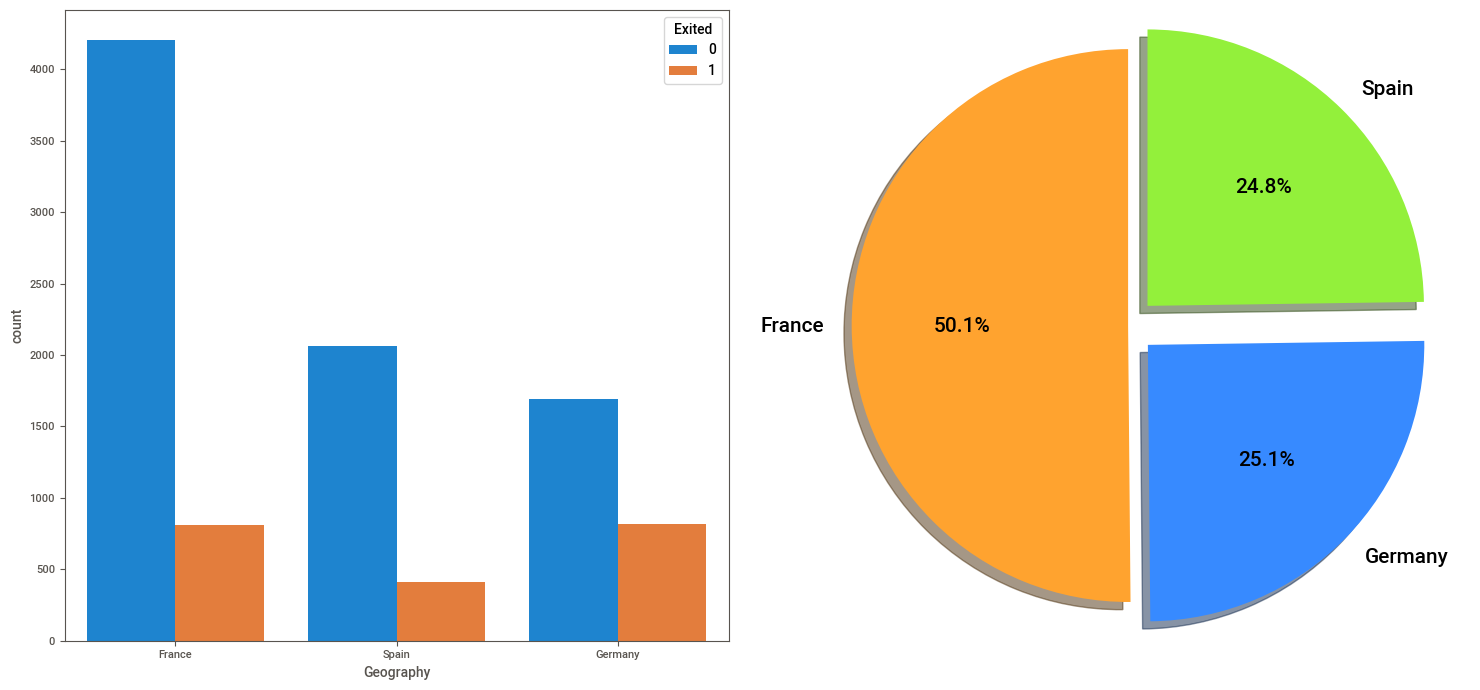

In [22]:
# Creating frequency table 
freq_table = df.groupby(['Geography']).size().reset_index(name='Count')
freq_table['0'] = freq_table['Geography'].apply(lambda x : df['Geography'][(df['Geography'] == x) & (df['Exited'] == 0)].count())
freq_table['1'] = freq_table['Geography'].apply(lambda x : df['Geography'][(df['Geography'] == x) & (df['Exited'] == 1)].count())

# Initializing lables and sizes for the pie chart 
labels = ['France', 'Germany', 'Spain']  # names on pie chart 
sizes = [df['Geography'][df['Geography'] == 'France'].count(),df['Geography'][df['Geography'] == 'Germany'].count(), df['Geography'][df['Geography'] == 'Spain'].count()]  
# only "explode" the 2nd and 3rd slice (i.e. 'France', 'Germany')
explode = (0, 0.1, 0.1)
#add colors   
colors = ['#FFA32F','#378AFF', '#93F03B'] 

fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
sns.countplot(x='Geography', data=df, hue='Exited', ax=ax[0])
# Equal aspect ratio ensures that pie is drawn as a circle
ax[1].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 15, 'fontWeight':'500'})
ax[1].axis('equal')
plt.tight_layout()
freq_table 

<IPython.core.display.Javascript object>

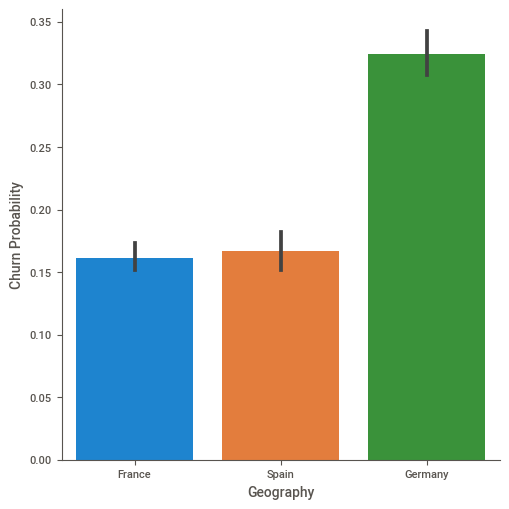

In [23]:
g=sns.factorplot(x = "Geography", y = "Exited", data = df, kind = "bar", size = 5)
g.set_ylabels("Churn Probability")
plt.show()

### Gender

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='Exited', ylabel='count'>

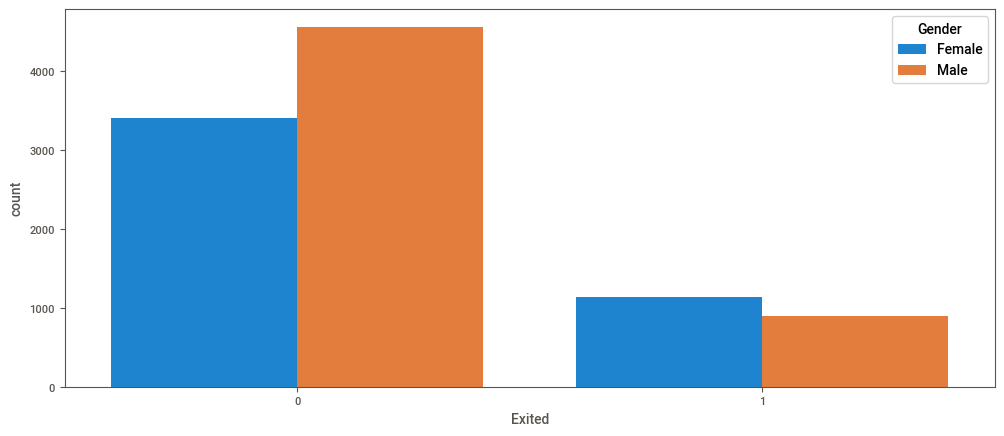

In [24]:
plt.figure(figsize=(12, 5))
sns.countplot(x='Exited', data=df, hue='Gender')
# px.histogram(df,x="Exited",color="Gender",barmode='group')

<IPython.core.display.Javascript object>

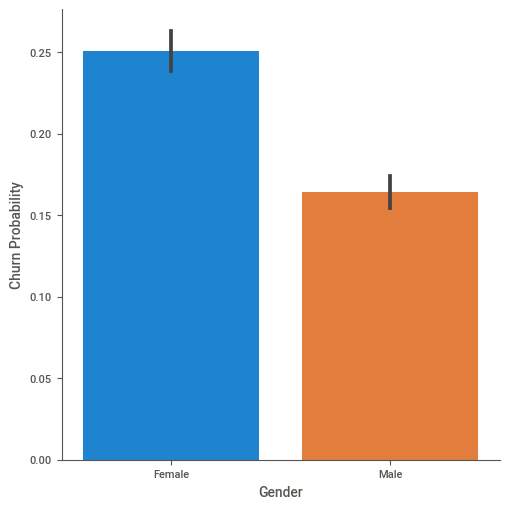

In [25]:
g= sns.factorplot(x = "Gender", y = "Exited", data = df, kind = "bar", size = 5)
g.set_ylabels("Churn Probability")
plt.show()

### Tenure

<IPython.core.display.Javascript object>

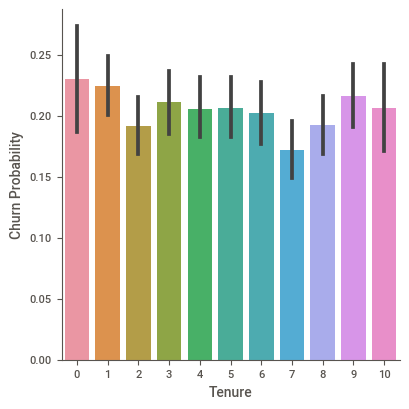

In [26]:
g= sns.factorplot(x = "Tenure", y = "Exited", data = df, kind = "bar", size = 4)
g.set_ylabels("Churn Probability")
plt.show()

### Age

The smallest age is 18 and the largest is 92


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='Age', ylabel='Density'>

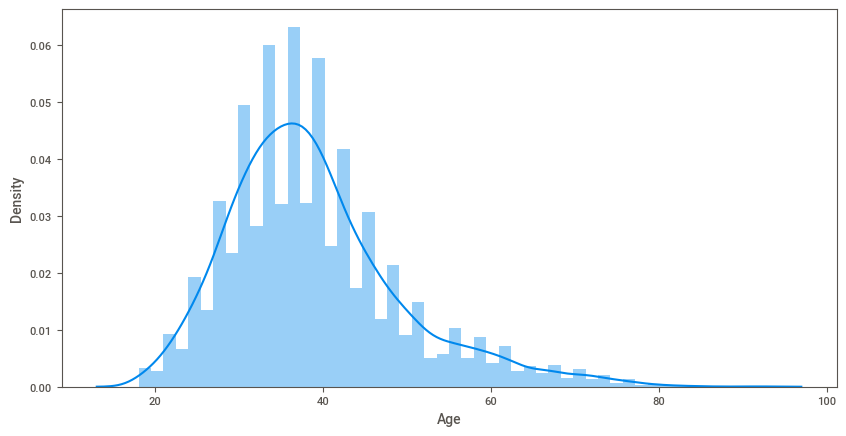

In [27]:
# distribution of age
print('The smallest age is {} and the largest is {}'.format(df.Age.min(), df.Age.max()))
plt.figure(figsize=(10, 5))
sns.distplot(df.Age)

<IPython.core.display.Javascript object>

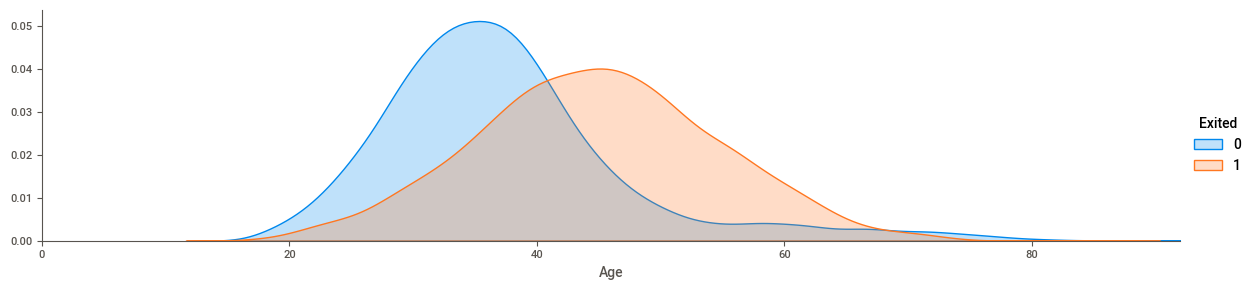

In [28]:
# distribution of age vs 'Exited'
facet = sns.FacetGrid(df,hue="Exited",aspect = 4)
facet.map(sns.kdeplot,"Age",shade = True)
facet.set(xlim = (0,df["Age"].max()))
facet.add_legend()
plt.show()

<IPython.core.display.Javascript object>

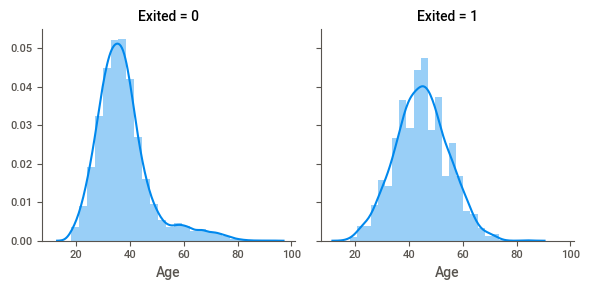

In [29]:
# distribution of age vs 'Exited'
g=sns.FacetGrid(df, col = "Exited")
g.map(sns.distplot, "Age", bins = 25)
plt.show()

### Distribution of balance vs number of products

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 600x400 with 0 Axes>

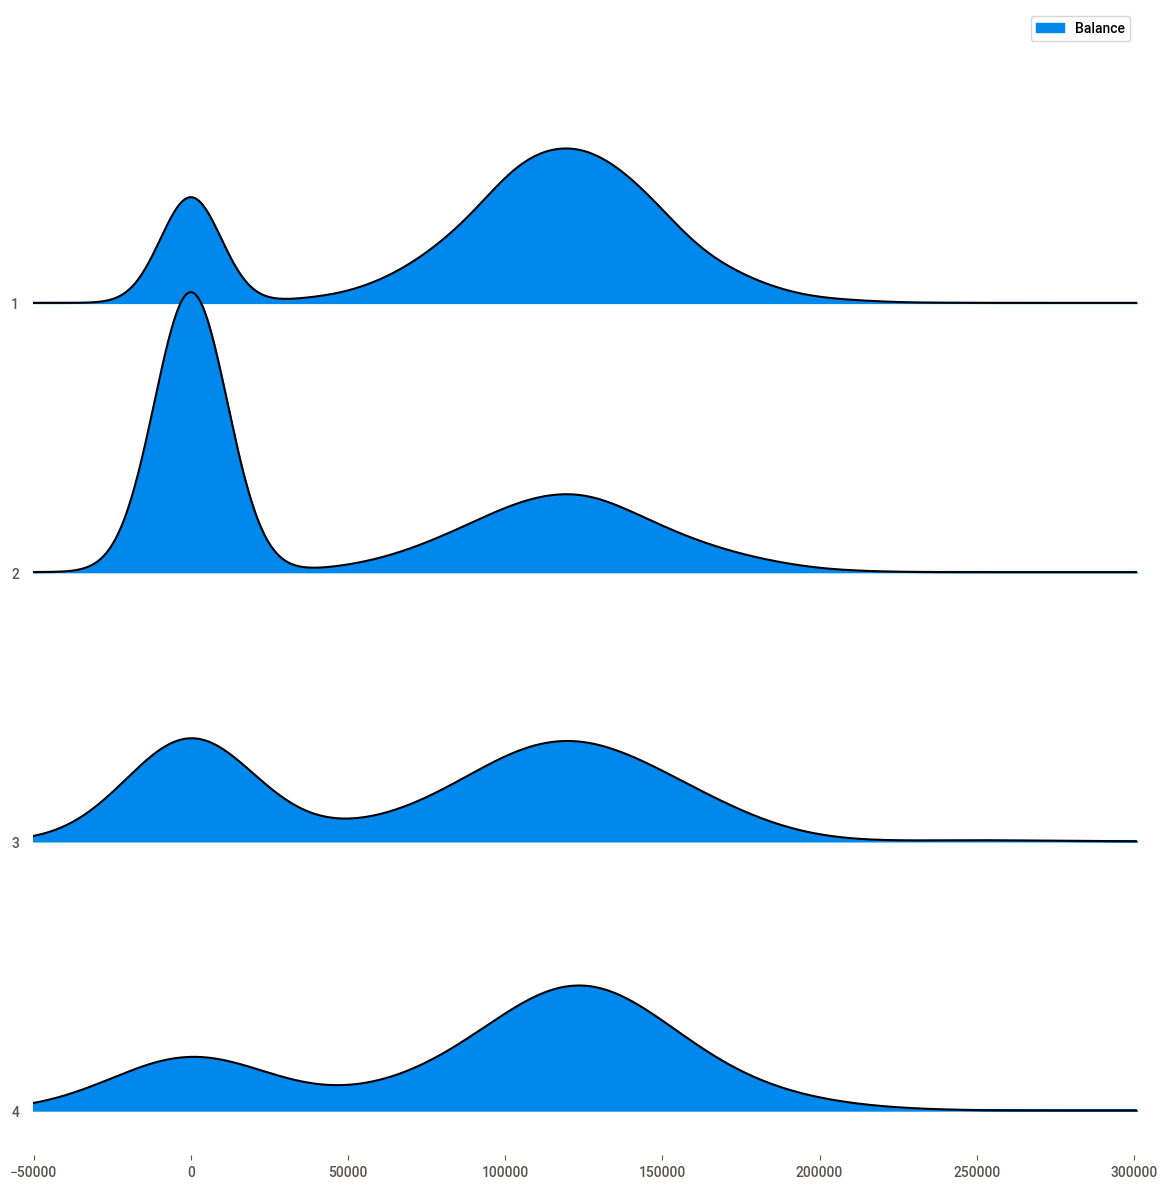

In [30]:
from joypy import joyplot
plt.figure()

joyplot(
    data=df[["Balance","NumOfProducts"]],
    by="NumOfProducts",
    column="Balance",
    figsize=(12,12 ),
    legend=True
)
plt.show()

### Balance

<IPython.core.display.Javascript object>

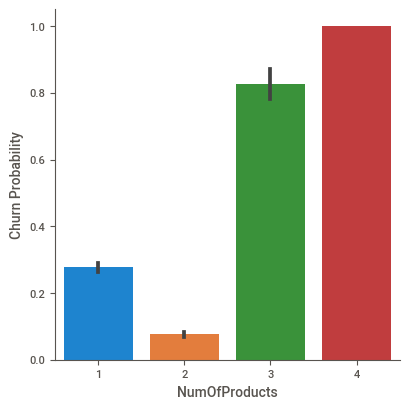

In [31]:
g = sns.factorplot(x = "NumOfProducts", y = "Exited", data = df, kind = "bar", size = 4)
g.set_ylabels("Churn Probability")
plt.show()

### Credit score

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

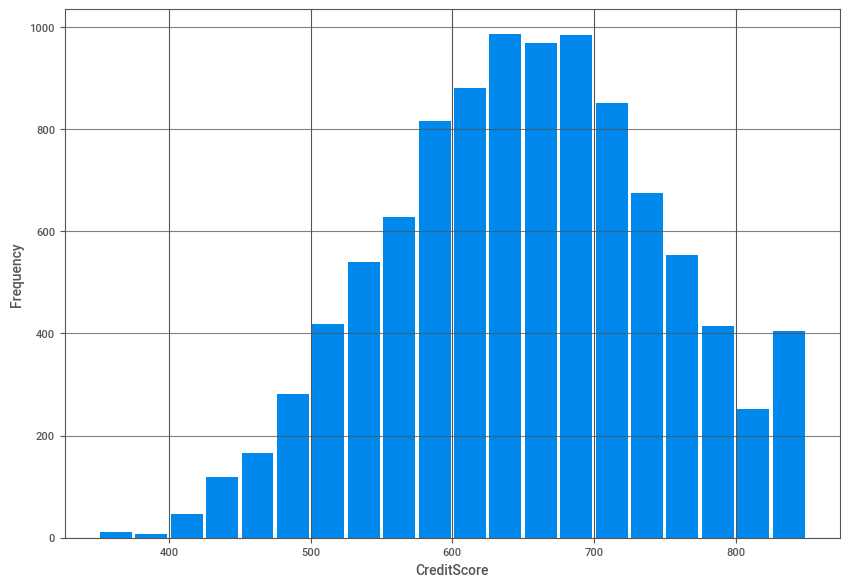

In [32]:

plt.figure(figsize=(10, 7))
df.CreditScore.plot.hist(grid=True, bins=20, rwidth=0.9)
plt.xlabel('CreditScore')
plt.grid(axis='y', alpha=0.75)
# import plotly.figure_factory as ff
# ff.create_distplot([df.CreditScore],['CreditScore'])

# Data preprocessing

In [33]:
print(df.select_dtypes(np.number).columns)
print(df.select_dtypes("object").columns)

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')
Index(['Geography', 'Gender'], dtype='object')


In [34]:
# One hot encoding Geography and Gender features 
geo_dummy=pd.get_dummies(df.Geography,drop_first=True)
gender_dummy=pd.get_dummies(df.Gender,drop_first=True)
df=pd.concat([geo_dummy,gender_dummy,df],axis=1)

In [35]:
# Drop unnecessary features 
df.drop(['Geography', 'Gender'], axis=1, inplace=True)

In [36]:
df

,Germany,Spain,Male,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,0,0,619,42,2,0.000000,1,1,1,101348.882812,1
1,0,1,0,608,41,1,83807.859375,1,0,1,112542.578125,0
2,0,0,0,502,42,8,159660.796875,3,1,0,113931.570312,1
3,0,0,0,699,39,1,0.000000,2,0,0,93826.632812,0
4,0,1,0,850,43,2,125510.820312,1,1,1,79084.101562,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,1,771,39,5,0.000000,2,1,0,96270.640625,0
9996,0,0,1,516,35,10,57369.609375,1,1,1,101699.773438,0
9997,0,0,0,709,36,7,0.000000,1,0,1,42085.578125,1
9998,1,0,1,772,42,3,75075.312500,2,1,0,92888.523438,1


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler

X=df.iloc[:,:-1]
y=df.iloc[:,-1]

# Spiliting the data into training and testing 
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=0)

# Standardize our data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# 3. Machine learning and deep learning models

# 3.1 PyCaret
PyCaret is an open source, low-code AutoML library in Python that allows you to go from preparing your data to deploying your model within minutes in your choice of notebook environment.

In [42]:
from pycaret.classification import *
clf1 = setup(df, target = 'Exited', log_experiment=True,train_size=0.8)

,Description,Value
0,session_id,487
1,Target,Exited
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(10000, 12)"
5,Missing Values,False
6,Numeric Features,11
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [43]:
best_model = compare_models(exclude=["catboost"],fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8625,0.8585,0.4528,0.7634,0.5683,0.4928,0.5167,0.2060
rf,Random Forest Classifier,0.8608,0.8452,0.4515,0.7529,0.5645,0.4877,0.5103,0.1920
lightgbm,Light Gradient Boosting Machine,0.8566,0.8509,0.4722,0.7139,0.5683,0.4866,0.5016,0.1140
ada,Ada Boost Classifier,0.8518,0.8367,0.4503,0.7017,0.5484,0.4648,0.4812,0.0780
et,Extra Trees Classifier,0.8515,0.8364,0.4097,0.7287,0.5242,0.4444,0.4704,0.1640
xgboost,Extreme Gradient Boosting,0.8508,0.8343,0.4740,0.6832,0.5592,0.4729,0.4847,0.4160
qda,Quadratic Discriminant Analysis,0.8289,0.8038,0.3559,0.6271,0.4540,0.3615,0.3820,0.0120
lda,Linear Discriminant Analysis,0.8089,0.7643,0.2189,0.5571,0.3141,0.2268,0.2605,0.0160
ridge,Ridge Classifier,0.8086,0.0000,0.1119,0.6219,0.1895,0.1366,0.2033,0.0120
lr,Logistic Regression,0.7935,0.6646,0.0532,0.3947,0.0934,0.0468,0.0792,0.0240


# 3.2 ML models created manually

In [45]:
random_state=0

models = [LogisticRegression(random_state=random_state),
          GaussianNB(), 
          KNeighborsClassifier(),
          SVC(random_state=random_state,probability=True),
          BaggingClassifier(random_state=random_state),
          DecisionTreeClassifier(random_state=random_state),
          RandomForestClassifier(random_state=random_state), 
          GradientBoostingClassifier(random_state=random_state),
          XGBClassifier(random_state=random_state), 
          CatBoostClassifier(random_state=random_state,verbose = False)]

names = ["LogisticRegression","GaussianNB","KNN","SVC","Bagging",
         "DecisionTree","Random_Forest","GBM","XGBoost","CatBoost"]

In [47]:
results = []
print('10 fold Cross validation accuracy and std of the default models for the train data:', end = "\n\n")
for name, model in zip(names, models):
    kfold = KFold(n_splits=5, random_state=random_state)
    cv_results = cross_val_score(model, X_train_full, y_train_full, cv = kfold, scoring = "accuracy")
    results.append(cv_results)
    print("{}: {} ({})".format(name, "%.3f" % cv_results.mean() ,"%.3f" %  cv_results.std()))

10 fold Cross validation accuracy and std of the default models for the train data:

LogisticRegression: 0.790 (0.014)
GaussianNB: 0.786 (0.013)
KNN: 0.757 (0.011)
SVC: 0.796 (0.009)
Bagging: 0.844 (0.004)
DecisionTree: 0.786 (0.011)
Random_Forest: 0.863 (0.003)
GBM: 0.862 (0.006)
[01:12:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:12:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:12:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:10

### Hyperparameters tuning

In [48]:
# Possible hyper parameters
logreg_params= {"C":np.logspace(-1, 1, 10),
                    "penalty": ["l1","l2"], "solver":['lbfgs', 'liblinear', 'sag', 'saga'], "max_iter":[1000]}

NB_params = {'var_smoothing': np.logspace(0,-9, num=100)}
knn_params= {"n_neighbors": np.linspace(1,19,10, dtype = int).tolist(),
                 "weights": ["uniform","distance"],
                 "metric":["euclidean","manhattan"]}
svc_params= {"kernel" : ["rbf"],
                 "gamma": [0.001, 0.01, 0.1, 1, 5, 10 ,50 ,100],
                 "C": [1,10,50,100,200,300,1000]}
bag_params={"n_estimators":[50,120,300]}
dtree_params = {"min_samples_split" : range(10,500,20),
                "max_depth": range(1,20,2)}
rf_params = {"max_features": ["log2","auto","sqrt"],
                "min_samples_split":[2,3,5],
                "min_samples_leaf":[1,3,5],
                "bootstrap":[True,False],
                "n_estimators":[50,100,150],
                "criterion":["gini","entropy"]}
gbm_params = {"learning_rate" : [0.001, 0.01, 0.1, 0.05],
             "n_estimators": [100,500,100],
             "max_depth": [3,5,10],
             "min_samples_split": [2,5,10]}
gbm_params = {"learning_rate" : [0.001, 0.01, 0.1, 0.05],
             "n_estimators": [100,500,100],
             "max_depth": [3,5,10],
             "min_samples_split": [2,5,10]}

xgb_params ={
        'n_estimators': [50, 100, 200],
        'subsample': [ 0.6, 0.8, 1.0],
        'max_depth': [1,2,3,4],
        'learning_rate': [0.1,0.2, 0.3, 0.4, 0.5],
        "min_samples_split": [1,2,4,6]}

mlpc_params = {"alpha": [0.1, 0.01, 0.02, 0.005, 0.0001,0.00001],
              "hidden_layer_sizes": [(10,10,10),
                                     (100,100,100),
                                     (100,100),
                                     (3,5), 
                                     (5, 3)],
              "solver" : ["lbfgs","adam","sgd"],"max_iter":[1000]}
catb_params =  {'depth':[2, 3, 4],
              'loss_function': ['Logloss', 'CrossEntropy'],
              'l2_leaf_reg':np.arange(2,31)}
classifier_params = [logreg_params,NB_params,knn_params,svc_params,bag_params,dtree_params,rf_params,
                     gbm_params, xgb_params,mlpc_params,catb_params]               
                  

In [49]:
import time
def timer(title):
    t0 = time.time()
    yield
    print("{} done in {:.0f}s".format(title, time.time() - t0))

In [ ]:
# Tuning by Cross Validation  
cv_result = {}
best_estimators = {}
for name, model,classifier_param in zip(names, models,classifier_params):
    with timer(">Model tuning"):
        clf = GridSearchCV(model, param_grid=classifier_param, cv =10, scoring = "accuracy", n_jobs = -1,verbose = False)
        clf.fit(x_train,y_train)
        cv_result[name]=clf.best_score_
        best_estimators[name]=clf.best_estimator_
        print(name,'cross validation accuracy : %.3f'%cv_result[name])

In [ ]:
accuracies={}
print('Validation accuracies of the tuned models for the train data:', end = "\n\n")
for name, model_tuned in zip(best_estimators.keys(),best_estimators.values()):
    y_pred =  model_tuned.fit(x_train,y_train).predict(x_val)
    accuracy=accuracy_score(y_pred, y_val)
    print(name,':', "%.3f" %accuracy)
    accuracies[name]=accuracy

In [ ]:
# Ensembling First n models

n=3
accu=sorted(accuracies, reverse=True, key= lambda k:accuracies[k])[:n]
firstn=[[k,v] for k,v in best_estimators.items() if k in accu]

votingC = VotingClassifier(estimators = firstn, voting = "soft", n_jobs = -1)
votingC = votingC.fit(x_train, y_train)
print(accuracy_score(votingC.predict(x_val),y_val))

# 3.3 Neural Network

In [50]:
from keras.models import Sequential
from keras.layers import Dense

#initialize model object
model = Sequential() 

model.add(Dense(32, activation='relu', kernel_initializer='normal', input_dim=11))
model.add(Dense(16, activation='relu', kernel_initializer='normal'))
model.add(Dense(1, activation='sigmoid', kernel_initializer='normal')) 

# Compiling the ANN
model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Fitting the model
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
restore_best_weights=True)
history=model.fit(X_train,y_train,epochs=100,validation_data=(X_val,y_val),callbacks=early_stopping_cb)


<IPython.core.display.Javascript object>

Epoch 1/100
200/200 [==============================] - 1s 4ms/step - loss: 0.6250 - accuracy: 0.7542 - val_loss: 0.4397 - val_accuracy: 0.7906
Epoch 2/100
200/200 [==============================] - 0s 1ms/step - loss: 0.4307 - accuracy: 0.8000 - val_loss: 0.4295 - val_accuracy: 0.7906
Epoch 3/100
200/200 [==============================] - 0s 1ms/step - loss: 0.4133 - accuracy: 0.8087 - val_loss: 0.4219 - val_accuracy: 0.8331
Epoch 4/100
200/200 [==============================] - 0s 1ms/step - loss: 0.4182 - accuracy: 0.8261 - val_loss: 0.4144 - val_accuracy: 0.8413
Epoch 5/100
200/200 [==============================] - 0s 1ms/step - loss: 0.4084 - accuracy: 0.8309 - val_loss: 0.4101 - val_accuracy: 0.8444
Epoch 6/100
200/200 [==============================] - 0s 1ms/step - loss: 0.4068 - accuracy: 0.8375 - val_loss: 0.4083 - val_accuracy: 0.8413
Epoch 7/100
200/200 [==============================] - 0s 1ms/step - loss: 0.3919 - accuracy: 0.8396 - val_loss: 0.4034 - val_accuracy: 0.8444

<AxesSubplot:>

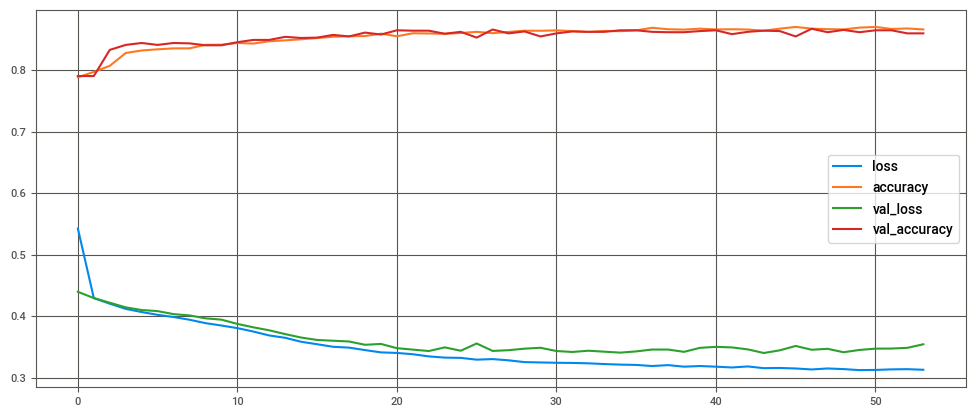

In [52]:
pd.DataFrame(history.history).plot(grid=True,figsize=(12,5))

In [53]:
model.evaluate(X_test,y_test)

63/63 [==============================] - 0s 1ms/step - loss: 0.3358 - accuracy: 0.8625


[0.33582329750061035, 0.862500011920929]

In [54]:
model.save('mymodel.h5')

In [55]:
# Predicting the test set
prediction = model.predict(X_test)
prediction = (prediction > 0.5)

In [57]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

print('Accuracy: {}% \n'.format(accuracy_score(y_test, prediction)* 100)) # Calculating accuracy 
print('*'*100)
print('F1 score: {}% \n'.format(round(f1_score(y_test, prediction)* 100,2))) # Calculating f1 score 
print('*'*100)
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))

 

Accuracy: 86.25% 

****************************************************************************************************
F1 score: 61.1% 

****************************************************************************************************
[[1509   86]
 [ 189  216]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1595
           1       0.72      0.53      0.61       405

    accuracy                           0.86      2000
   macro avg       0.80      0.74      0.76      2000
weighted avg       0.85      0.86      0.85      2000



# 3.4 XGBoost

In [58]:
# Hyper Parameter Optimization for xgboost
params = {
    "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
    "learning_rate": [0.5, 0.10, 0.15, 0.20, 0.25, 0.30],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7]
}
## Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost
xgb_init = xgboost.XGBClassifier()
random_cv = RandomizedSearchCV(xgb_init, param_distributions=params, n_iter=5, scoring="roc_auc", n_jobs=1, cv=5, verbose=3)
random_cv.fit(X, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] min_child_weight=3, max_depth=12, learning_rate=0.1, gamma=0.4, colsample_bytree=0.4 
[01:18:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_child_weight=3, max_depth=12, learning_rate=0.1, gamma=0.4, colsample_bytree=0.4, score=0.848, total=   0.9s
[CV] min_child_weight=3, max_depth=12, learning_rate=0.1, gamma=0.4, colsample_bytree=0.4 
[01:18:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  min_child_weight=3, max_depth=12, learning_rate=0.1, gamma=0.4, colsample_bytree=0.4, score=0.848, total=   0.9s
[CV] min_child_weight=3, max_depth=12, learning_rate=0.1, gamma=0.4, colsample_bytree=0.4 
[01:18:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  min_child_weight=3, max_depth=12, learning_rate=0.1, gamma=0.4, colsample_bytree=0.4, score=0.852, total=   0.9s
[CV] min_child_weight=3, max_depth=12, learning_rate=0.1, gamma=0.4, colsample_bytree=0.4 
[01:18:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=3, max_depth=12, learning_rate=0.1, gamma=0.4, colsample_bytree=0.4, score=0.854, total=   0.9s
[CV] min_child_weight=3, max_depth=12, learning_rate=0.1, gamma=0.4, colsample_bytree=0.4 
[01:18:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if 

[CV]  min_child_weight=7, max_depth=4, learning_rate=0.1, gamma=0.4, colsample_bytree=0.3, score=0.864, total=   0.3s
[CV] min_child_weight=7, max_depth=4, learning_rate=0.1, gamma=0.4, colsample_bytree=0.3 
[01:18:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=7, max_depth=4, learning_rate=0.1, gamma=0.4, colsample_bytree=0.3, score=0.862, total=   0.3s
[CV] min_child_weight=5, max_depth=4, learning_rate=0.1, gamma=0.4, colsample_bytree=0.4 
[01:18:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   12.9s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n...
                                           verbosity=None),
                   iid='deprecated', n_iter=5, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.

In [59]:
random_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [60]:
random_cv.best_params_

{'min_child_weight': 5,
 'max_depth': 4,
 'learning_rate': 0.1,
 'gamma': 0.4,
 'colsample_bytree': 0.4}

In [61]:
xgb_classifier = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [62]:
predict = cross_val_score(xgb_classifier, X, y, cv=10)
predict

[01:18:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:18:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:18:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:18:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

array([0.88 , 0.855, 0.877, 0.861, 0.861, 0.855, 0.869, 0.874, 0.861,
       0.856])

In [63]:
predict = predict.mean()
predict

0.8648999999999999